# Modelling the Kalgoorlie fault network from seismic and map data

In [7]:
os.chdir("C:/Users/aafo0002/Documents/GitHub/Kalgoorlie_fault_network/GA_2022_presentation")

In [8]:
import geopandas as gpd # read shapefiles
import numpy as np # array manipulation
import pandas as pd # dataframes
import os # paths
import matplotlib.pyplot as plt # plotting
plt.rcParams.update({'font.size': 12})
import mplstereonet

from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer, RotationAnglePlotter
from LoopStructural.modelling import ProcessInputData
from LoopStructural.utils import dtm_creator

In [9]:
def darken_color(color, amount=1.5):

    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

#### Two types of input per fault:

 * xyz points that define the fault at the surface (from map data)
 * xyz points that define the fault at depth (from seismic)

In [12]:
# surface data
Ida_surface = gpd.read_file('./data/Surface_points/Ida_pts_elevation.shp') ###

Ida_surface = pd.DataFrame({'X': Ida_surface.geometry.x, 
                        'Y': Ida_surface.geometry.y, 
                        'Z': Ida_surface.DEM_main_m})

Ida_surface['fault_name'] = "Ida Fault"

In [13]:
# seismic data
Ida_seismic = gpd.read_file("./data/Seismic_points/Ida_fault.shp") ###
Ida_seismic = Ida_seismic[['X', 'Y', 'depth_minu', 'FAULT']]
Ida_seismic.columns = Ida_surface.columns

all_Ida_pts = pd.concat([Ida_surface, Ida_seismic]).reset_index(drop=True)

#### What do these datasets look like

In [14]:
Ida_surface.head(5)

,X,Y,Z,fault_name
0,271505.033161,6.653013e+06,484.89725,Ida Fault
1,271534.906994,6.650885e+06,479.95044,Ida Fault
2,271567.311298,6.648576e+06,485.75809,Ida Fault
3,271490.457037,6.646502e+06,483.78461,Ida Fault
4,271517.857466,6.645928e+06,485.84747,Ida Fault


In [15]:
Ida_seismic.head(3)

,X,Y,Z,fault_name
0,326846.92,6620664.73,-27829.86,Ida Fault
1,328157.80,6620693.26,-28274.49,Ida Fault
2,332962.46,6621100.44,-30448.47,Ida Fault


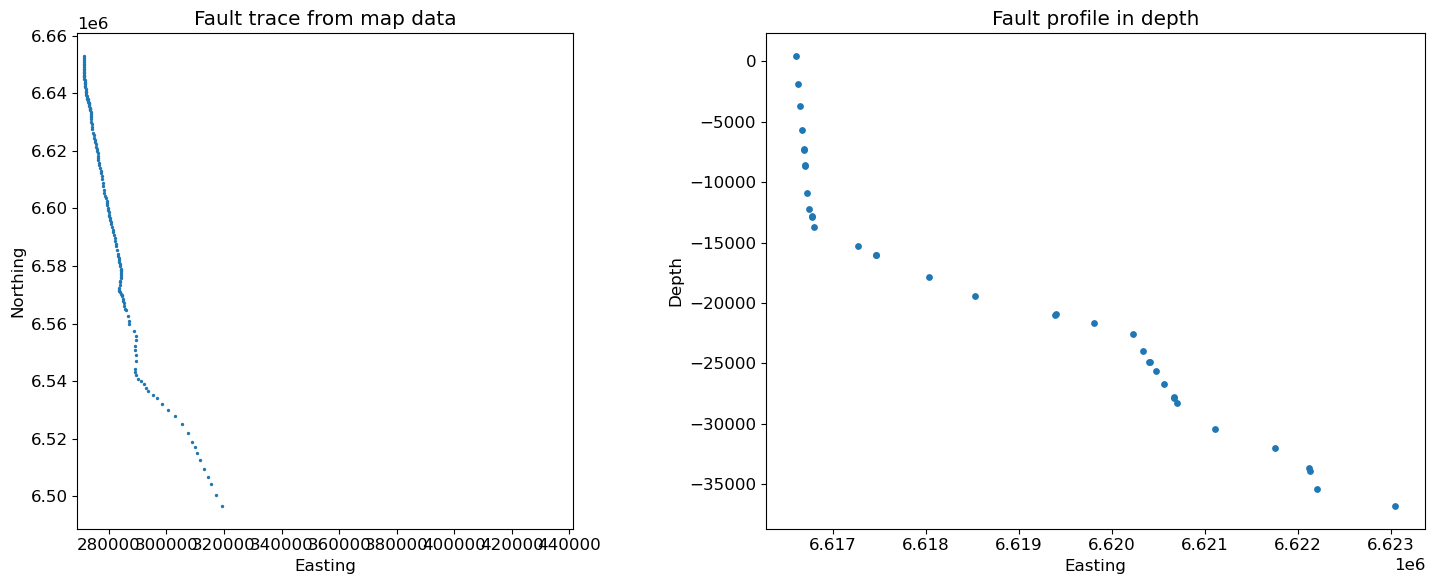

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (15, 6))
ax = ax.flatten()

ax[0].scatter(Ida_surface['X'], Ida_surface['Y'], s = 2)
ax[0].axis('square'), ax[0].set_title("Fault trace from map data"), 
ax[0].set_ylabel("Northing"), ax[0].set_xlabel("Easting")

ax[1].scatter(Ida_seismic['Y'], Ida_seismic['Z'], s = 15) 
ax[1].set_xlabel("Easting"), ax[1].set_ylabel("Depth")
ax[1].set_title("Fault profile in depth"), 

plt.tight_layout()
plt.show()

#### Two types of faults' subsurface data: 
* Some faults have only one seismic section that defines the fault geometry (e.g., Ida fault), 
* and there are other faults that have several seismic lines at depth

In [20]:
Kunanalling_seismic = gpd.read_file("./data/Seismic_points/Kunanalling_fault.shp")
Kunanalling_seismic = Kunanalling_seismic[['X', 'Y', 'depth_minu', 'FAULT']]
Kunanalling_seismic.columns = ['X', 'Y', 'Z', 'fault_name']
Kunanalling_seismic['fault_name'] = "Kunanalling Fault"

Kunanalling_surface = gpd.read_file("./data/Surface_points/Kunanalling_pts_elevation.shp")
Kunanalling_surface = pd.DataFrame({'X': Kunanalling_surface.geometry.x, 
                                    'Y': Kunanalling_surface.geometry.y, 
                                    'Z': Kunanalling_surface.DEM_main, 
                                    'fault_name': 'Kunanalling Fault'})

In [21]:
view0 = LavaVuModelViewer()
view0.add_points(Ida_seismic[['X', 'Y', 'Z']], name = 'Ida seismic', pointsize = 10, colour = '#b2df8a')
view0.add_points(Ida_surface[['X', 'Y', 'Z']], name = 'Ida surface', pointsize = 10, colour = darken_color('#b2df8a'))

view0.add_points(Kunanalling_seismic[['X', 'Y', 'Z']], name = 'Kunanalling seismic', pointsize = 10, colour = '#1f78b4')
view0.add_points(Kunanalling_surface[['X', 'Y', 'Z']], name = 'Kunanalling surface', pointsize = 10, colour = '#1f78b4')

view0.rotation = [-60.989593505859375, -11.66930866241455, -3.0865814685821533]
view0.set_zscale(2.87)
view0.interactive()

# Modelling Kunanalling Fault
## Case 1 - when the seismic data contains several point lines at depth

If we have a set of points with x, y, z, we can find the function of the corresponding coefficients of the surface by using the general formula $ax + by + c = z$. 

The norm of these coefficients will give us the gradient constraints to input in LoopStructural. 

Source: https://stackoverflow.com/questions/1400213/3d-least-squares-plane

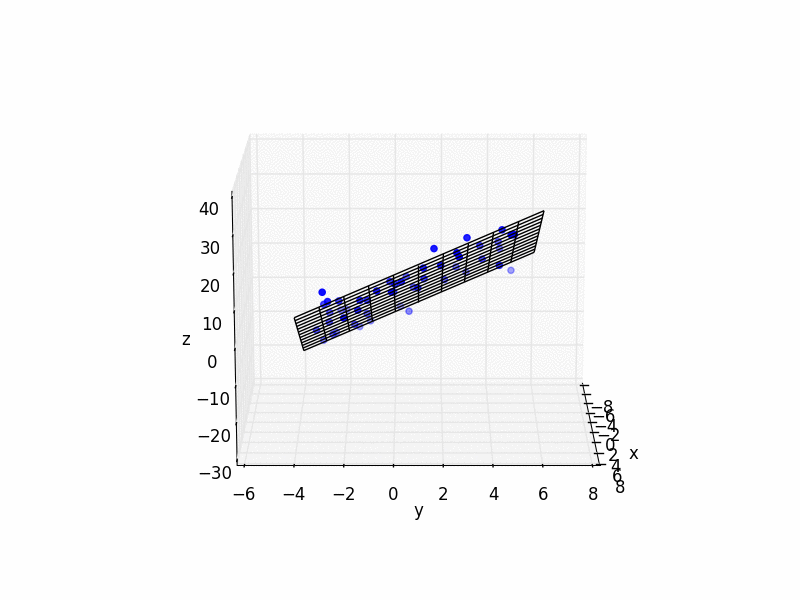

In [22]:
from IPython.display import Image
Image("./images/oi7dw.gif", width = 600, height = 400)

In [23]:
# solve the 3D least squares

tmpA = []
tmpB = []

xs = Kunanalling_seismic['X'].to_numpy()
ys = Kunanalling_seismic['Y'].to_numpy()
zs = Kunanalling_seismic['Z'].to_numpy()

for j in range(len(xs)):
    tmpA.append([xs[j], ys[j], 1])
    tmpB.append(zs[j])

b = np.matrix(tmpB).T
A = np.matrix(tmpA)

fit = (A.T * A).I * A.T * b

kdr = pd.DataFrame({'gx': [fit[0, 0]], 'gy': fit[1, 0], 'gz': -1})

kdr /= np.linalg.norm(kdr)

In [24]:
meanX = Kunanalling_surface['X'].mean()
meanY = Kunanalling_surface['Y'].mean()
meanZ = zs.mean()

gs = []
gs.append(['Kunanalling Fault', meanX, meanY, meanZ, 
           kdr['gx'][0], 
           kdr['gy'][0],
           kdr['gz'][0]])

ori = pd.DataFrame(gs, columns = ['fault_name', 'X', 'Y', 'Z', 'gx', 'gy', 'gz'])

ori

,fault_name,X,Y,Z,gx,gy,gz
0,Kunanalling Fault,325759.559201,6.574631e+06,-4068.768056,-0.459887,-0.336245,-0.821853


# Initiate the model

In [25]:
updated_data = pd.concat([Kunanalling_seismic, Kunanalling_surface])

origin = [214794.5029269870719872, 6501887.2589999996125698, -40000]
maximum = [400411.4882275541312993, 6653021.2462467299774289, 5000]

In [26]:
processor1 = ProcessInputData(fault_locations = updated_data, fault_orientations = ori,
                             origin = origin, maximum = maximum)

                This will result in only a fault surface, no displacement on older features


In [27]:
model1 = GeologicalModel(origin, maximum)

model1.data = processor1.data

model1.create_and_add_fault('Kunanalling Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                          cpw = 0.05, npw = 5
                          )
model1.update()

  0%|          | 0/3 [00:00<?, ?it/s]

In [28]:
view1 = LavaVuModelViewer(model1)

view1.add_isosurface(model1['Kunanalling Fault'], colours = ['#a6fff3'], value = 0)

view1.add_points(Kunanalling_seismic[['X', 'Y', 'Z']], pointsize = 10, name = 'Kunanalling_seismic_pts')
view1.add_points(Kunanalling_surface[['X', 'Y', 'Z']], pointsize = 10, name = 'Kunanalling_surface_pts')
view1.add_data(model1['Kunanalling Fault'], vectors = True)

view1.interactive()

Object exists: Kunanalling Fault_value_cp
Object exists: Kunanalling Fault_value_cp


# Model the Ida Fault

## Case 2 - when the seismic data contains one point lines at depth

In [29]:
# solve the 3d least squares
gs = []

tmpA = []
tmpB = []

xs = Ida_seismic['X'].to_numpy()
ys = Ida_seismic['Y'].to_numpy()
zs = Ida_seismic['Z'].to_numpy()

for j in range(len(xs)):
    tmpA.append([xs[j], ys[j], 1])
    tmpB.append(zs[j])

b = np.matrix(tmpB).T
A = np.matrix(tmpA)

fit = (A.T * A).I * A.T * b

# find the norms
kdr = pd.DataFrame({'gx': [fit[0,0]], 
                  'gy': fit[1,0], 
                  'gz': -1})

kdr /= np.linalg.norm(kdr)

In [30]:
meanX = Ida_surface['X'].mean()
meanY = Ida_surface['Y'].mean()
meanZ = zs.mean()

gs.append(['Ida Fault', meanX, meanY, meanZ, 
           kdr['gx'][0], 
           kdr['gy'][0],
           kdr['gz'][0]])

ori = pd.DataFrame(gs, columns = ['fault_name', 'X', 'Y', 'Z', 'gx', 'gy', 'gz'])
ori

,fault_name,X,Y,Z,gx,gy,gz
0,Ida Fault,281825.12709,6.595975e+06,-19118.905,-0.248679,0.903545,-0.34895


In [31]:
updated_data = pd.concat([Ida_seismic, Ida_surface])

In [32]:
processor2 = ProcessInputData(fault_locations = updated_data, fault_orientations = ori,
                             origin=origin, maximum=maximum)

model2 = GeologicalModel(origin, maximum)

model2.data = processor2.data

model2.create_and_add_fault('Ida Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True)

model2.update()

                This will result in only a fault surface, no displacement on older features


  0%|          | 0/3 [00:00<?, ?it/s]

In [33]:
view2 = LavaVuModelViewer(model2)

view2.add_isosurface(model2['Ida Fault'], colours = ['#a6cee3'], value = 0)

view2.add_data(model2['Ida Fault'][0])
view2.add_points(Ida_seismic[['X', 'Y', 'Z']], pointsize = 10, name = 'Ida_seismic_pts')
view2.add_points(Ida_surface[['X', 'Y', 'Z']], pointsize = 10, name = 'Ida_surface_pts')

view2.interactive()

In [ ]:
min_xy = Ida_surface[["X", "Y", "Z"]].to_numpy()[0, :]
max_xy = Ida_surface[["X", "Y", "Z"]].to_numpy()[-1, :]

tangent_xy = max_xy - min_xy
norm_xy = tangent_xy / np.linalg.norm(tangent_xy)
norm_xy

In [ ]:
max_z = Ida_seismic[Ida_seismic['Z']==Ida_seismic['Z'].max()][['X', 'Y', 'Z']].to_numpy()
min_z = Ida_seismic[Ida_seismic['Z']==Ida_seismic['Z'].min()][['X', 'Y', 'Z']].to_numpy()

tangent_z1 = (max_z - min_z)
norm_z = tangent_z1 / np.linalg.norm(tangent_z1)
norm_z

In [ ]:
CP = np.cross(norm_xy, norm_z)
CP

In [ ]:
ori = pd.DataFrame(CP)
ori['fault_name'] = "Ida Fault"
ori.columns = ['gx', 'gy', 'gz', 'fault_name']

ori['X'] = Ida_surface['X'].mean()
ori['Y'] = Ida_surface['Y'].mean()
ori['Z'] = Ida_seismic['Z'].mean()

ori = ori[['X', 'Y', 'Z', 'fault_name', 'gx', 'gy', 'gz']]
ori

In [ ]:
processor3 = ProcessInputData(fault_locations = updated_data, fault_orientations = ori,
                             origin=origin, maximum=maximum)

model3 = GeologicalModel(origin, maximum)

model3.data = processor3.data

model3.create_and_add_fault('Ida Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                          npw=5, cpw = 0.05
                          )

model3.update()

In [ ]:
view3 = LavaVuModelViewer(model3)

view3.add_isosurface(model3['Ida Fault'], colours = ['#a6cee3'], value = 0)

view3.add_data(model3['Ida Fault'][0])
view3.add_points(Ida_seismic[['X', 'Y', 'Z']], pointsize = 10, name = 'Ida_seismic_pts')
view3.add_points(Ida_surface[['X', 'Y', 'Z']], pointsize = 10, name = 'Ida_surface_pts')

view3.interactive()

# Ida and Kunanalling in the same model

In [34]:
updated_data = pd.read_csv("./data/Full_datasets/updated_data_v11.csv")
updated_oris = pd.read_csv("./data/Full_datasets/ori_df_v10.csv")
######
full_path_DEM = "./data/Full_datasets/DEM_v3.tif"

In [35]:
processor4 = ProcessInputData(fault_locations = updated_data, fault_orientations = updated_oris,
                            origin = origin, maximum = maximum)

c:\Users\aafo0002\Anaconda3\envs\new_loop\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


In [36]:
origin = [214794.5029269870719872, 6491887.2589999996125698, -40000]
maximum = [400411.4882275541312993, 6683021.2462467299774289, 5000]

model4 = GeologicalModel(origin, maximum)

model4.data = processor4.data

model4.dtm = dtm_creator.create_dtm_with_rasterio(full_path_DEM) 

model4.create_and_add_fault('Ida Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                          npw = 5, cpw = 0.05)

model4.create_and_add_fault('Kunanalling Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                          npw = 5, cpw = 0.05)

model4.update(verbose = True)

Updating geological model. There are: 
 6                     geological features that need to be interpolated



  0%|          | 0/6 [00:00<?, ?it/s]

Model update took: 20.06939148902893 seconds


In [37]:
view4 = LavaVuModelViewer(model4)
view4.add_isosurface(model4['Ida Fault'], colours = ['#a6cee3'], value = 0)
view4.add_isosurface(model4['Kunanalling Fault'], colours = ['#a6fff3'], value = 0)
view4.add_data(model4['Ida Fault'][0])
view4.add_data(model4['Kunanalling Fault'][0])

view4.interactive()

In [ ]:
#Add abutting relationships
model4['Kunanalling Fault'].add_abutting_fault(model4['Ida Fault'])

In [ ]:
view5 = LavaVuModelViewer(model4)
view5.nelements = 1e6
view5.add_isosurface(model4['Ida Fault'], colours = ['#a6cee3'], value = 0)
view5.add_isosurface(model4['Kunanalling Fault'], colours = ['#a6fff3'], value = 0)
view5.add_data(model4['Ida Fault'][0])
view5.add_data(model4['Kunanalling Fault'][0])

view5.interactive()

# Adding all the fault traces and seismic into a single model

In [ ]:
processor6 = ProcessInputData(fault_locations = updated_data, fault_orientations = updated_oris, origin=origin, maximum=maximum)

model6 = GeologicalModel(origin = [214794.5029269870719872, 6501887.2589999996125698, -40000], 
                        maximum = [400411.4882275541312993, 6653021.2462467299774289, 5000])

model6.data = processor6.data

model6.dtm = dtm_creator.create_dtm_with_rasterio(full_path_DEM) 

model6.create_and_add_fault('Boulder Lefroy Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, 
                           regularization = [5,5,5])
model6.create_and_add_fault('Boorara Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                           cpw = 0.2, regularisation = [5, 5, 5])
model6.create_and_add_fault('Abattoir East Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False)
model6.create_and_add_fault('Abattoir West Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, cpw = .25)
model6.create_and_add_fault('Zuleika Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cpw = .05)

model6.create_and_add_fault('Ida Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, npw=5, cpw = 0.05)
model6.create_and_add_fault('Kunanalling Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, npw = 5, cpw = 0.05)

model6.create_and_add_fault('Bulla_Abut_South', displacement = 5, nelements=1e4)
model6.create_and_add_fault('Bulla_Abut_North', displacement = 5, nelements=1e4)
model6.create_and_add_fault('Bullabulling South Fault', displacement = 5, nelements=1e4, cpw = 0.2)
model6.create_and_add_fault('Bullabulling North Fault', displacement = 5, nelements=1e4, cpw = 0.2)

model6.create_and_add_fault('MtMonger Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cwp = 0.2)
model6.create_and_add_fault('Kanowna Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, cpw=0.2)

model6.create_and_add_fault('Black Flag Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False)
model6.create_and_add_fault('Speedway Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False)
model6.create_and_add_fault('Tramways Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False)

model6.update(verbose=True)

In [ ]:
view = LavaVuModelViewer(model6)

fault_list = ['Ida Fault', 'Kunanalling Fault', 'Bulla_Abut_South', 'Bulla_Abut_North', 'Bullabulling South Fault', 
              'Bullabulling North Fault', 'MtMonger Fault', 'Zuleika Fault', 'Kanowna Fault', 'Boorara Fault', 'Boulder Lefroy Fault',
              'Abattoir East Fault', 'Abattoir West Fault', 'Black Flag Fault','Speedway Fault', 'Tramways Fault']
color_list = ['#a6cee3', '#b2df8a', '#1f78b4', '#1f78b4','#33a02c', '#33a02c', '#e31a1c', '#fb9a99', '#fdbf6f', '#ff7f00', '#cab2d6', 
             '#ffff99', '#7d8b8f', '#b15928', 'green', 'blue']
for i in range(0, len(fault_list)):
    view.add_isosurface(model6[fault_list[i]], colours = [color_list[i]], value = 0)

view.interactive()

# Adding all the abutting relationships

![2_together.png](attachment:2_together.png)

![all.png](attachment:all.png)

In [ ]:
model6['Black Flag Fault'].add_abutting_fault(model6['Boorara Fault'])
model6['Black Flag Fault'].add_abutting_fault(model6['Zuleika Fault'])
model6['Tramways Fault'].add_abutting_fault(model6['Boorara Fault'])
model6['Boorara Fault'].add_abutting_fault(model6['Kanowna Fault'])
model6['Boorara Fault'].add_abutting_fault(model6['MtMonger Fault'])
model6['Bullabulling North Fault'].add_abutting_fault(model6['Bulla_Abut_North'])
model6['Bullabulling South Fault'].add_abutting_fault(model6['Bulla_Abut_South'])
model6['Bulla_Abut_South'].add_abutting_fault(model6['Ida Fault'])
model6['Bullabulling North Fault'].add_abutting_fault(model6['Kunanalling Fault'])
model6['Bulla_Abut_North'].add_abutting_fault(model6['Ida Fault'])
model6['Bullabulling North Fault'].add_abutting_fault(model6['Kanowna Fault'])
model6['Kunanalling Fault'].add_abutting_fault(model6['Ida Fault'])
model6['Kunanalling Fault'].add_abutting_fault(model6['Boulder Lefroy Fault'])
model6['Kunanalling Fault'].add_abutting_fault(model6['Boorara Fault'])
model6['Kanowna Fault'].add_abutting_fault(model6['MtMonger Fault'])
model6['Kanowna Fault'].add_abutting_fault(model6['Ida Fault'])
model6['MtMonger Fault'].add_abutting_fault(model6['Ida Fault'])

In [ ]:
model6['Boulder Lefroy Fault'].add_abutting_fault(model6['Boorara Fault'])
model6['Abattoir West Fault'].add_abutting_fault(model6['Boorara Fault'])
model6['Abattoir East Fault'].add_abutting_fault(model6['Boorara Fault'])
model6['Abattoir West Fault'].add_abutting_fault(model6['Boulder Lefroy Fault'])
model6['Abattoir East Fault'].add_abutting_fault(model6['Boulder Lefroy Fault'])
model6['Abattoir West Fault'].add_abutting_fault(model6['Zuleika Fault'])
model6['Abattoir East Fault'].add_abutting_fault(model6['Zuleika Fault'])
model6['Speedway Fault'].add_abutting_fault(model6['Boulder Lefroy Fault'])
model6['Speedway Fault'].add_abutting_fault(model6['Abattoir East Fault'])
model6['Speedway Fault'].add_abutting_fault(model6['Zuleika Fault'])
model6['Zuleika Fault'].add_abutting_fault(model6['Boulder Lefroy Fault'])
model6['Tramways Fault'].add_abutting_fault(model6['Speedway Fault'])
model6['Boulder Lefroy Fault'].add_abutting_fault(model6['Ida Fault'])
model6['Zuleika Fault'].add_abutting_fault(model6['Kanowna Fault'])
model6['Zuleika Fault'].add_abutting_fault(model6['Boorara Fault'])
model6['Black Flag Fault'].add_abutting_fault(model6['Kanowna Fault'])
model6['Boulder Lefroy Fault'].add_abutting_fault(model6['Kanowna Fault'])
model6['Abattoir West Fault'].add_abutting_fault(model6['Abattoir East Fault'])

In [ ]:
view6 = LavaVuModelViewer(model6)
view6.nelements = 1e6

fault_list = ['Ida Fault', 'Kunanalling Fault', 'Bulla_Abut_South', 'Bulla_Abut_North', 'Bullabulling South Fault', 
              'Bullabulling North Fault', 'MtMonger Fault', 'Zuleika Fault', 'Kanowna Fault', 'Boorara Fault', 'Boulder Lefroy Fault',
              'Abattoir East Fault', 'Abattoir West Fault', 'Black Flag Fault','Speedway Fault', 'Tramways Fault']
color_list = ['#a6cee3', '#b2df8a', '#1f78b4', '#1f78b4','#33a02c', '#33a02c', '#e31a1c', '#fb9a99', '#fdbf6f', '#ff7f00', '#cab2d6', 
             '#ffff99', '#7d8b8f', '#b15928', 'green', 'blue']

for i in range(0, len(fault_list)):
    view6.add_isosurface(model6[fault_list[i]], colours = [color_list[i]], value = 0)
view6.interactive()